# 🔄 Online learning for time series prediction 🔄

We implement the online learning filter developped in [1].

In the first part of this notebook, we reproduce
the "setting 1" of [1] and show how to setup a training environment with WAX-ML to study improper learning of ARMA time-series models.

We finally study how
to reproduce the other settings (2, 3, 4) of [1], which are non-stationnary environments.

We use the following modules from WAX-ML:
- ARMA : to generate a modeled time-series
- SNARIMAX : to adaptively learn to predict the generated time-series.
- GymFeedback: To setup a training loop.
- VMap: to add batch dimensions to the training loop
- optim.newton: a newton algorithm as used in [1] and developped in [2]. It extends optax optimizers.

## References

[1] [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June. Online learning for time series prediction. In Conference on learning theory (pp. 172-184)](https://arxiv.org/pdf/1302.6927.pdf)

[2] [Hazan, E., Agarwal, A. and Kale, S., 2007. Logarithmic regret algorithms for
online convex optimization. Machine Learning, 69(2-3), pp.169-192](https://link.springer.com/content/pdf/10.1007/s10994-007-5016-8.pdf)

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from typing import Any, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from wax.modules import (
    ARMA,
    SNARIMAX,
    GymFeedback,
    Lag,
    OnlineOptimizer,
    UpdateParams,
    VMap,
)
from wax.optim import newton
from wax.unroll import unroll_transform_with_state


# ARMA

Let's generate a sample of the "setting 1" of [1]:

In [3]:
alpha = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
beta = jnp.array([0.3, -0.2])

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
sim = unroll_transform_with_state(lambda eps: ARMA(alpha, beta)(eps))
params, state = sim.init(rng, eps)
y, state = sim.apply(params, state, rng, eps)
y.shape

(1000,)

# SNARIMAX

Let's setup an online model to try to learn the dynamic of the time-series.

First let's run the filter with it's initial random weights.

<AxesSubplot:>

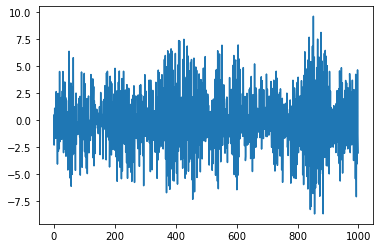

In [4]:
def predict(y, X=None):
    return SNARIMAX(10, 0, 0)(y, X)


sim = unroll_transform_with_state(predict)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10,))
params, state = sim.init(rng, y)
(y_pred, _), state = sim.apply(params, state, rng, y)

pd.Series((y - y_pred)).plot()

In [5]:
def evaluate(y_pred, y):
    return jnp.linalg.norm(y_pred - y) ** 2, {}


def lag(shift=1):
    def __call__(y, X=None):
        yp = Lag(shift)(y)
        Xp = Lag(shift)(X) if X is not None else None
        return yp, Xp

    return __call__


def predict_and_evaluate(y, X=None):
    # predict with lagged data
    y_pred, pred_info = predict(*lag(1)(y, X))

    # evaluate loss with actual data
    loss, loss_info = evaluate(y_pred, y)

    return loss, dict(pred_info=pred_info, loss_info=loss_info)

<AxesSubplot:>

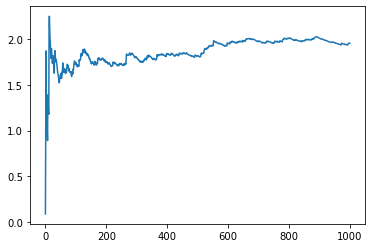

In [6]:
sim = unroll_transform_with_state(predict_and_evaluate)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(loss, _), state = sim.apply(params, state, rng, y)

pd.Series(loss).expanding().mean().plot()

Since the model is not trained and the coefficient of the SNARIMAX filter a choosen randomly, the loss may diverge

In [7]:
params

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'w': DeviceArray([[-0.47023755],
                                           [ 0.07070494],
                                           [-0.07388116],
                                           [ 0.13453043],
                                           [ 0.07728617],
                                           [ 0.0851969 ],
                                           [-0.03324771],
                                           [ 0.17115903],
                                           [ 0.1023274 ],
                                           [-0.4804019 ]], dtype=float32),
                         'b': DeviceArray([0.], dtype=float32),
                       }),
})

# Learn

## Setup projection

In [8]:
def project_params(params, opt_state=None):
    w = params["snarimax/~/linear"]["w"]
    w = jnp.clip(w, -1, 1)
    params["snarimax/~/linear"]["w"] = w
    return params


project_params(hk.data_structures.to_mutable_dict(params))

{'snarimax/~/linear': {'w': DeviceArray([[-0.47023755],
               [ 0.07070494],
               [-0.07388116],
               [ 0.13453043],
               [ 0.07728617],
               [ 0.0851969 ],
               [-0.03324771],
               [ 0.17115903],
               [ 0.1023274 ],
               [-0.4804019 ]], dtype=float32),
  'b': DeviceArray([0.], dtype=float32)}}

In [9]:
def learn(y, X=None):
    optim_res = OnlineOptimizer(
        predict_and_evaluate, optax.sgd(1.0e-2), project_params=project_params
    )(y, X)
    return optim_res

<AxesSubplot:>

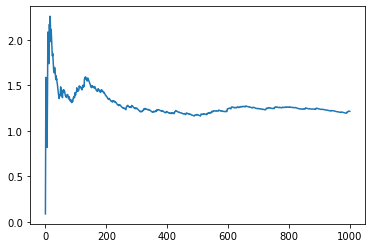

In [10]:
sim = unroll_transform_with_state(learn)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, eps)
optim_res, state = sim.apply(params, state, rng, eps)

pd.Series(optim_res.loss).expanding().mean().plot()

Let's look at the latest weights:

In [11]:
jax.tree_map(lambda x: x[-1], optim_res.updated_params)

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'b': DeviceArray([-0.14335798], dtype=float32),
                         'w': DeviceArray([[-0.06957585],
                                           [ 0.11199051],
                                           [-0.14902674],
                                           [-0.02122167],
                                           [-0.03742805],
                                           [ 0.00436568],
                                           [-0.10548005],
                                           [-0.05702855],
                                           [-0.01185708],
                                           [-0.01168777]], dtype=float32),
                       }),
})

# Learn and Forecast

In [12]:
class ForecastInfo(NamedTuple):
    optim: Any
    forecast: Any

In [13]:
def learn_and_forecast(y, X=None):
    optim_res = OnlineOptimizer(
        predict_and_evaluate, optax.sgd(1.0e-3), project_params=project_params
    )(*lag(1)(y, X))

    predict_params = optim_res.updated_params

    forecast, forecast_info = UpdateParams(predict)(predict_params, y, X)
    return forecast, ForecastInfo(optim_res, forecast_info)

<AxesSubplot:>

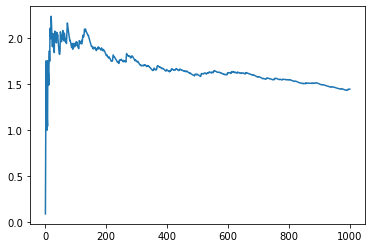

In [14]:
sim = unroll_transform_with_state(learn_and_forecast)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(forecast, info), state = sim.apply(params, state, rng, y)

pd.Series(info.optim.loss).expanding().mean().plot()

# Gym simulation

## Environment

let's build an environment corresponding to "setting 1" in [1]

In [15]:


def build_env():
    def env(action, obs):
        y_pred, eps = action, obs
        ar_coefs = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ma_coefs = jnp.array([0.3, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env

In [16]:
env = build_env()

## Agent

In [17]:
from optax._src.base import OptState

In [18]:


def build_agent(time_series_model=None, opt=None):
    if time_series_model is None:
        time_series_model = lambda y, X: SNARIMAX(10)(y, X)

    if opt is None:
        opt = optax.sgd(1.0e-3)

    class AgentInfo(NamedTuple):
        optim: Any
        forecast: Any

    class ModelWithLossInfo(NamedTuple):
        pred: Any
        loss: Any

    def agent(obs):
        if isinstance(obs, tuple):
            y, X = obs
        else:
            y = obs
            X = None

        def evaluate(y_pred, y):
            return jnp.linalg.norm(y_pred - y) ** 2, {}

        def model_with_loss(y, X=None):
            # predict with lagged data
            y_pred, pred_info = time_series_model(*lag(1)(y, X))

            # evaluate loss with actual data
            loss, loss_info = evaluate(y_pred, y)

            return loss, ModelWithLossInfo(pred_info, loss_info)

        def project_params(params: Any, opt_state: OptState = None):
            del opt_state
            return jax.tree_map(lambda w: jnp.clip(w, -1, 1), params)

        def split_params(params):
            def filter_params(m, n, p):
                # print(m, n, p)
                return m.endswith("snarimax/~/linear") and n == "w"

            return hk.data_structures.partition(filter_params, params)

        def learn_and_forecast(y, X=None):
            optim_res = OnlineOptimizer(
                model_with_loss,
                opt,
                project_params=project_params,
                split_params=split_params,
            )(*lag(1)(y, X))

            predict_params = optim_res.updated_params

            y_pred, forecast_info = UpdateParams(time_series_model)(
                predict_params, y, X
            )
            return y_pred, AgentInfo(optim_res, forecast_info)

        return learn_and_forecast(y, X)

    return agent

In [19]:
agent = build_agent()

## Gym loop

In [20]:
def gym_loop(eps):
    return GymFeedback(agent, env)(eps)

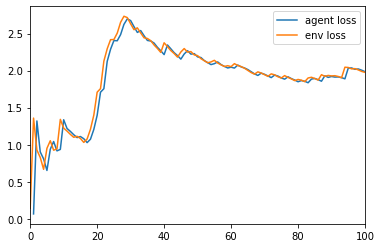

In [21]:
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000,))
sim = unroll_transform_with_state(gym_loop)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)
pd.Series(info.agent.optim.loss).expanding().mean().plot(label="agent loss")
pd.Series(-gym.reward).expanding().mean().plot(xlim=(0, 100), label="env loss")
plt.legend()

<AxesSubplot:>

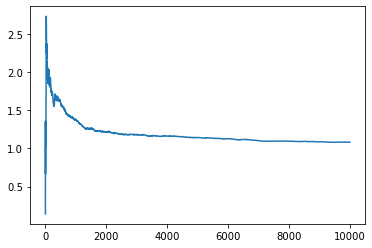

In [22]:
pd.Series(-gym.reward).expanding().mean().plot()  # ylim=(0.09, 0.15))

We see that the agent suffers the same loss as the environment but with a time lag.

# Batch simulations

## Average over 20 experiments

## Slow version

First, let's do it "naively" by doing a simple python "for loop".

In [23]:
%%time
rng = jax.random.PRNGKey(42)
sim = unroll_transform_with_state(gym_loop)

res = {}
for i in tqdm(onp.arange(20)):
    rng, _ = jax.random.split(rng)
    eps = jax.random.normal(rng, (10000,)) * 0.3
    params, state = sim.init(rng, eps)
    (gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)
    res[i] = gym_info

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 14 s, sys: 197 ms, total: 14.2 s
Wall time: 13.9 s


<AxesSubplot:>

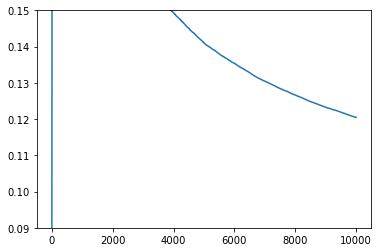

In [24]:
pd.DataFrame({k: pd.Series(v.agent.optim.loss) for k, v in res.items()}).mean(
    1
).expanding().mean().plot(ylim=(0.09, 0.15))

## Fast version with vmap

Instead of using a "for loop" we can use jax's vmap transformation function!

In [25]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (20, 10000)) * 0.3

rng = jax.random.PRNGKey(42)
rng = jax.random.split(rng, num=20)
sim = unroll_transform_with_state(gym_loop)
params, state = jax.vmap(sim.init)(rng, eps)
(gym_output, gym_info), final_state = jax.vmap(sim.apply)(params, state, rng, eps)

CPU times: user 2.22 s, sys: 60.7 ms, total: 2.28 s
Wall time: 2.3 s


This is much faster!

<AxesSubplot:>

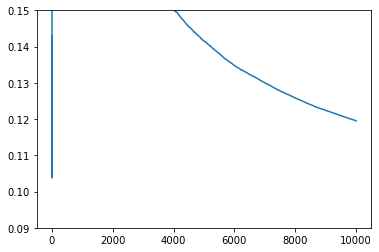

In [26]:
pd.DataFrame(gym_info.agent.optim.loss).mean().expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

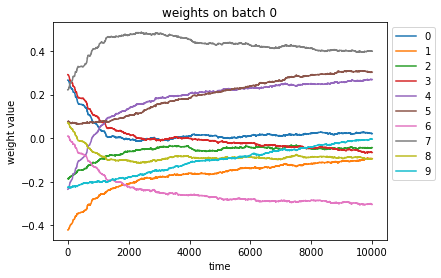

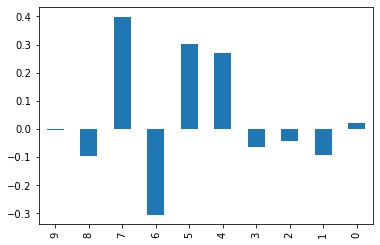

In [27]:
i_batch = 0
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][i_batch, :, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

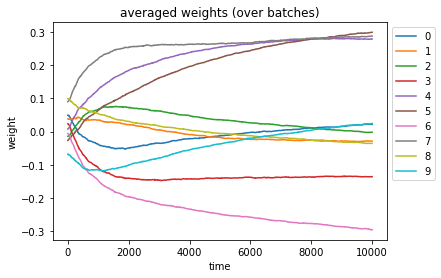

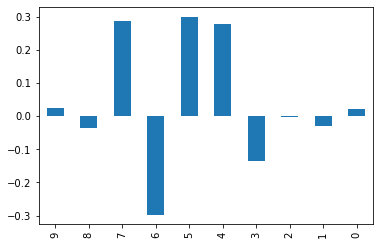

In [28]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"].mean(axis=0)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

## With VMap module

We can use the wrapper module `VMap` of WAX-ML. It permits to have an ever simpler syntax.

> Note: we have to swap in position of time and batch dimension in the generation of eps.

In [29]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3


def batched_gym_loop(eps):
    return VMap(gym_loop)(eps)


sim = unroll_transform_with_state(batched_gym_loop)

rng = jax.random.PRNGKey(43)
params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.82 s, sys: 34.1 ms, total: 1.85 s
Wall time: 1.8 s


In [30]:
pd.DataFrame(gym_info.agent.optim.loss).shape

(10000, 20)

<AxesSubplot:>

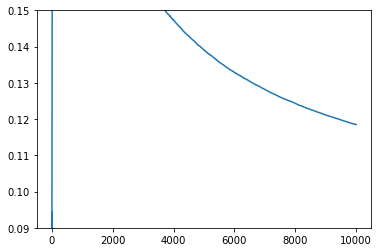

In [31]:
pd.DataFrame(gym_info.agent.optim.loss).mean(1).expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

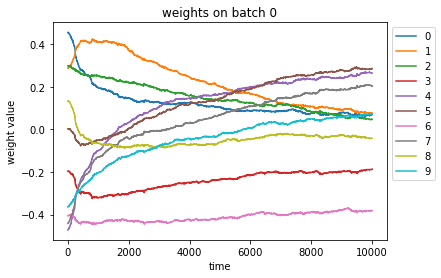

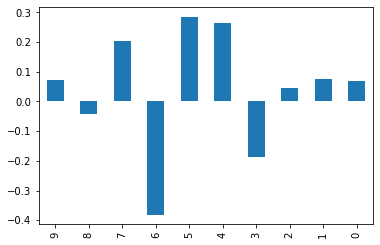

In [32]:
i_batch = 0
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][:, i_batch, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

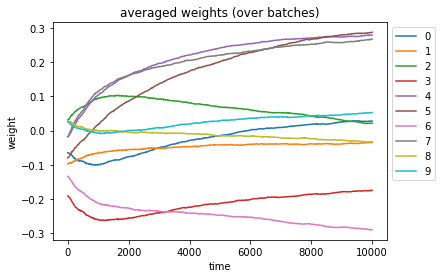

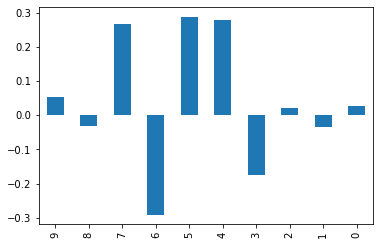

In [33]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"].mean(axis=1)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

## Taking mean inside simulation

In [34]:
%%time


def add_batch(fun, take_mean=True):
    def fun_batch(*args, **kwargs):
        res = VMap(fun)(*args, **kwargs)
        if take_mean:
            res = jax.tree_map(lambda x: x.mean(axis=0), res)
        return res

    return fun_batch


gym_loop_batch = add_batch(gym_loop)
sim = unroll_transform_with_state(gym_loop_batch)

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3

params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.59 s, sys: 23.7 ms, total: 1.61 s
Wall time: 1.59 s


<AxesSubplot:>

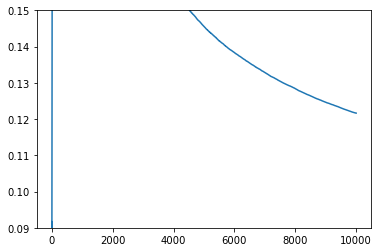

In [35]:
pd.Series(-gym_output.reward).expanding().mean().plot(ylim=(0.09, 0.15))

<AxesSubplot:>

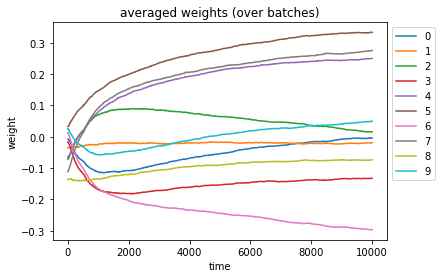

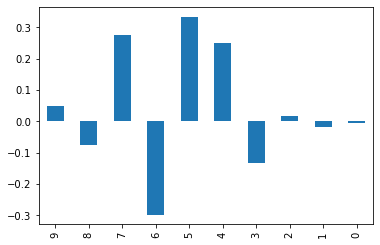

In [36]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

# Hyper parameter tuning

## First order optimizers

We will consider different first order optimizers, namely:
- SGD
- ADAM
- ADAGRAD

For each of them, we will scan the "step_size" parameter $\eta$.

We will average results over batches of size 40.

We will consider trajectories of size 10.000.

Finally, we will pickup the best parameter based of the minimum averaged loss for the last 5000 time steps.

In [37]:
%%time

STEP_SIZE_idx = pd.Index(onp.logspace(-4, 1, 30), name="step_size")
STEP_SIZE = jax.device_put(STEP_SIZE_idx.values)
OPTIMIZERS = [optax.sgd, optax.adam, optax.adagrad]

res = {}
for optimizer in tqdm(OPTIMIZERS):

    def gym_loop_scan_hparams(eps):
        def scan_params(step_size):
            return GymFeedback(build_agent(opt=optimizer(step_size)), env)(eps)

        res = VMap(scan_params)(STEP_SIZE)
        return res

    sim = unroll_transform_with_state(add_batch(gym_loop_scan_hparams))
    rng = jax.random.PRNGKey(42)
    eps = jax.random.normal(rng, (10000, 40)) * 0.3

    params, state = sim.init(rng, eps)
    _res, state = sim.apply(params, state, rng, eps)
    res[optimizer.__name__] = _res


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 12.5 s, sys: 183 ms, total: 12.7 s
Wall time: 12.6 s


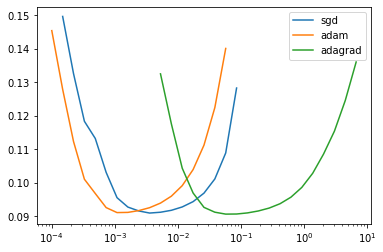

In [38]:
ax = None
BEST_STEP_SIZE = {}
BEST_GYM = {}
for name, (gym, info) in res.items():

    loss = pd.DataFrame(-gym.reward, columns=STEP_SIZE).iloc[-5000:].mean()

    BEST_STEP_SIZE[name] = loss.idxmin()
    best_idx = loss.reset_index(drop=True).idxmin()
    BEST_GYM[name] = jax.tree_map(lambda x: x[:, best_idx], gym)

    ax = loss[loss < 0.15].plot(logx=True, logy=False, ax=ax, label=name)
plt.legend()

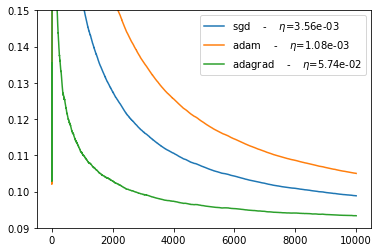

In [39]:
for name, gym in BEST_GYM.items():
    ax = (
        pd.Series(-gym.reward)
        .expanding()
        .mean()
        .plot(
            label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
        )
    )
ax.legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

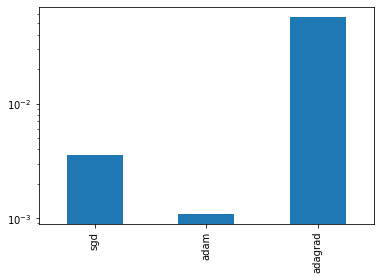

In [40]:
pd.Series(BEST_STEP_SIZE).plot(kind="bar", logy=True)

## Newton algorithm

Now let's consider the newton algorithm.

First let's test it with one set of parameter with average over 20 batches.

In [41]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.05, eps=20.0)), env)(eps)


sim = unroll_transform_with_state(gym_loop_newton)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3

params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

CPU times: user 2.04 s, sys: 51.5 ms, total: 2.09 s
Wall time: 1.89 s


<AxesSubplot:>

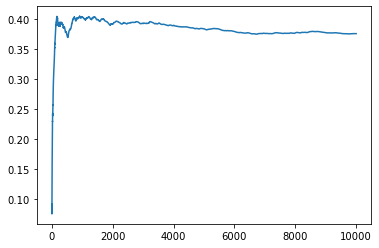

In [42]:
pd.Series(-gym.reward).expanding().mean().plot()

In [43]:
%%time

STEP_SIZE = pd.Index(onp.logspace(-2, 3, 10), name="step_size")
EPS = pd.Index(onp.logspace(-4, 3, 5), name="eps")

HPARAMS_idx = pd.MultiIndex.from_product([STEP_SIZE, EPS])
HPARAMS = jnp.stack(list(map(onp.array, HPARAMS_idx)))


@add_batch
def gym_loop_scan_hparams(eps):
    def scan_params(hparams):
        step_size, newton_eps = hparams
        agent = build_agent(opt=newton(step_size, eps=newton_eps))
        return GymFeedback(agent, env)(eps)

    return VMap(scan_params)(HPARAMS)


sim = unroll_transform_with_state(gym_loop_scan_hparams)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 40)) * 0.3

params, state = sim.init(rng, eps)
res_newton, state = sim.apply(params, state, rng, eps)

CPU times: user 16.2 s, sys: 381 ms, total: 16.6 s
Wall time: 16.1 s


In [44]:
gym_newton, info_newton = res_newton

In [45]:
loss_newton = pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).mean().unstack()

In [46]:
loss_newton = (
    pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).iloc[-5000:].mean().unstack()
)

Best newton parameters:  0.464158883361278 0.31622776601683794


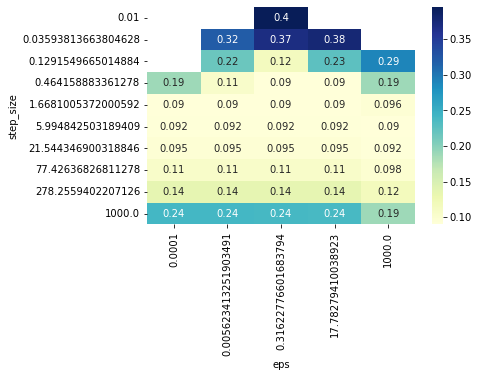

In [47]:
sns.heatmap(loss_newton[loss_newton < 0.4], annot=True, cmap="YlGnBu")

STEP_SIZE, NEWTON_EPS = loss_newton.stack().idxmin()

x = -gym_newton.reward[-5000:].mean(axis=0)
x = jax.ops.index_update(x, jnp.isnan(x), jnp.inf)
I_BEST_PARAM = jnp.argmin(x)


BEST_NEWTON_GYM = jax.tree_map(lambda x: x[:, I_BEST_PARAM], gym_newton)
print("Best newton parameters: ", STEP_SIZE, NEWTON_EPS)

Text(0.5, 1.0, 'Rolling mean of loss (5000) time-steps')

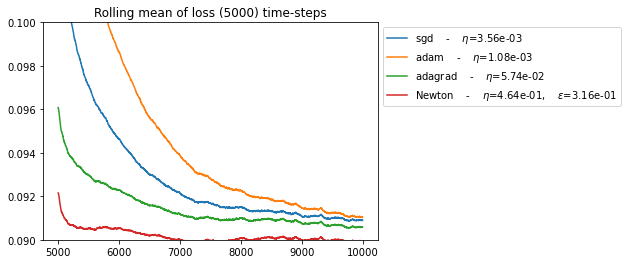

In [48]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).rolling(5000, min_periods=5000).mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.1)
    )

gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .rolling(5000, min_periods=5000)
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("Rolling mean of loss (5000) time-steps")

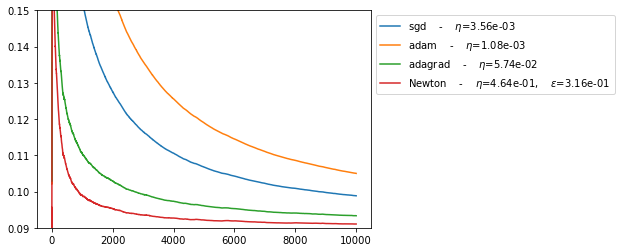

In [49]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).expanding().mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
    )
gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .expanding()
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))

In agreement with Hazan's paper, we see that Newton's algorithm performs much better than sgd.

In addition, we note that
- adam does not perform well in this online setting.
- adagrad performormance is between newton and sgd.

# Non-stationnary environments

We will now wrapup the study of an environment + agent in few analysis functions.

We will then use them to perform the sam analysis on the non-stationnary setting proposed in [1], namely
- setting 2 : slowly varaying parameters.
- setting 3 : brutal variation of parameters.
- setting 4 : non-stationnary (random walk) noise.

## Analysis functions

For each solver, we will select the best hyper parameters (step size $\eta$, $epsilon$) by mesuring the averaged loss over the 5000 first time steps.

In [50]:
LEARN_TIME_SLICE = slice(5000, 10000)

### First order solvers

In [51]:
def scan_hparams_first_order():

    STEP_SIZE_idx = pd.Index(onp.logspace(-4, 1, 30), name="step_size")
    STEP_SIZE = jax.device_put(STEP_SIZE_idx.values)
    OPTIMIZERS = [optax.sgd, optax.adam, optax.adagrad]

    rng = jax.random.PRNGKey(42)
    eps = sample_noise(rng)

    res = {}
    for optimizer in tqdm(OPTIMIZERS):

        def gym_loop_scan_hparams(eps):
            def scan_params(step_size):
                return GymFeedback(build_agent(opt=optimizer(step_size)), env)(eps)

            res = VMap(scan_params)(STEP_SIZE)
            return res

        sim = unroll_transform_with_state(add_batch(gym_loop_scan_hparams))

        params, state = sim.init(rng, eps)
        _res, state = sim.apply(params, state, rng, eps)
        res[optimizer.__name__] = _res

    ax = None
    BEST_STEP_SIZE = {}
    BEST_GYM = {}

    for name, (gym, info) in res.items():

        loss = (
            pd.DataFrame(-gym.reward, columns=STEP_SIZE).iloc[LEARN_TIME_SLICE].mean()
        )

        BEST_STEP_SIZE[name] = loss.idxmin()

        best_idx = jnp.argmax(gym.reward[LEARN_TIME_SLICE].mean(axis=0))
        BEST_GYM[name] = jax.tree_map(lambda x: x[:, best_idx], gym)

        ax = loss.plot(
            logx=True, logy=False, ax=ax, label=name, ylim=(MIN_ERR, MAX_ERR)
        )
    plt.legend()

    return BEST_STEP_SIZE, BEST_GYM

We will "cross-validate" the result by running the agent on new samples.

In [52]:
CROSS_VAL_RNG = jax.random.PRNGKey(44)

In [53]:
COLORS = sns.color_palette("hls")

In [54]:
def cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM):
    plt.figure()
    eps = sample_noise(CROSS_VAL_RNG)
    CROSS_VAL_GYM = {}
    ax = None

    def measure(reward):
        return pd.Series(-reward).rolling(5000, min_periods=5000).mean()

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    for i, (name, gym) in enumerate(BEST_GYM.items()):
        ax = measure(gym.reward).plot(
            ax=ax,
            color=COLORS[i],
            label=(f"(TRAIN) -  {name}    " f"-    $\eta$={BEST_STEP_SIZE[name]:.2e}"),
            style="--",
        )
    for i, optimizer in enumerate(tqdm(OPTIMIZERS)):

        name = optimizer.__name__

        def gym_loop(eps):
            return GymFeedback(build_agent(opt=optimizer(BEST_STEP_SIZE[name])), env)(
                eps
            )

        sim = unroll_transform_with_state(add_batch(gym_loop))

        params, state = sim.init(rng, eps)
        (gym, info), state = sim.apply(params, state, rng, eps)
        CROSS_VAL_GYM[name] = gym

        ax = measure(gym.reward).plot(
            ax=ax,
            color=COLORS[i],
            ylim=(MIN_ERR, MAX_ERR),
            label=(
                f"(VALIDATE) -  {name}    " f"-    $\eta$={BEST_STEP_SIZE[name]:.2e}"
            ),
        )
    plt.legend()

    return CROSS_VAL_GYM

### Newton solver

In [55]:
def scan_hparams_newton():
    STEP_SIZE = pd.Index(onp.logspace(-2, 3, 10), name="step_size")
    EPS = pd.Index(onp.logspace(-4, 3, 5), name="eps")

    HPARAMS_idx = pd.MultiIndex.from_product([STEP_SIZE, EPS])
    HPARAMS = jnp.stack(list(map(onp.array, HPARAMS_idx)))

    @add_batch
    def gym_loop_scan_hparams(eps):
        def scan_params(hparams):
            step_size, newton_eps = hparams
            agent = build_agent(opt=newton(step_size, eps=newton_eps))
            return GymFeedback(agent, env)(eps)

        return VMap(scan_params)(HPARAMS)

    sim = unroll_transform_with_state(gym_loop_scan_hparams)

    rng = jax.random.PRNGKey(42)
    eps = sample_noise(rng)

    params, state = sim.init(rng, eps)
    res_newton, state = sim.apply(params, state, rng, eps)

    gym_newton, info_newton = res_newton

    loss_newton = pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).mean().unstack()

    loss_newton = (
        pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx)
        .iloc[LEARN_TIME_SLICE]
        .mean()
        .unstack()
    )

    sns.heatmap(loss_newton[loss_newton < 0.4], annot=True, cmap="YlGnBu")

    STEP_SIZE, NEWTON_EPS = loss_newton.stack().idxmin()

    x = -gym_newton.reward[LEARN_TIME_SLICE].mean(axis=0)
    x = jax.ops.index_update(x, jnp.isnan(x), jnp.inf)
    I_BEST_PARAM = jnp.argmin(x)

    BEST_NEWTON_GYM = jax.tree_map(lambda x: x[:, I_BEST_PARAM], gym_newton)
    print("Best newton parameters: ", STEP_SIZE, NEWTON_EPS)
    return (STEP_SIZE, NEWTON_EPS), BEST_NEWTON_GYM

In [56]:


def cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM):
    (STEP_SIZE, NEWTON_EPS) = BEST_HPARAMS
    plt.figure()

    eps = sample_noise(CROSS_VAL_RNG)
    CROSS_VAL_GYM = {}
    ax = None

    def measure(reward):
        return pd.Series(-reward).rolling(5000, min_periods=5000).mean()

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    @add_batch
    def gym_loop(eps):
        agent = build_agent(opt=newton(STEP_SIZE, eps=NEWTON_EPS))
        return GymFeedback(agent, env)(eps)

    sim = unroll_transform_with_state(gym_loop)

    rng = jax.random.PRNGKey(44)
    eps = sample_noise(rng)
    params, state = sim.init(rng, eps)
    (gym, info), state = sim.apply(params, state, rng, eps)

    ax = None
    name = "Newton"
    i = 3
    ax = measure(BEST_NEWTON_GYM.reward).plot(
        ax=ax,
        color=COLORS[i],
        label=f"(TRAIN) -  Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
        ylim=(MIN_ERR, MAX_ERR),
        style="--",
    )

    ax = measure(gym.reward).plot(
        ax=ax,
        color=COLORS[i],
        ylim=(MIN_ERR, MAX_ERR),
        label=f"(VALIDATE) - Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
    )

    plt.legend()

    return gym

### Plot everithing

In [57]:
def plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM):

    rng = jax.random.PRNGKey(43)
    eps = sample_noise(rng)

    MESURES = []

    def measure(reward):
        return pd.Series(-reward).rolling(5000, min_periods=5000).mean()

    MESURES.append(("Rolling mean of loss (5000) time-steps", measure))

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    MESURES.append(("Expanding means", measure))

    for MEASURE_NAME, MEASUR_FUNC in MESURES:

        plt.figure()

        for i, (name, gym) in enumerate(BEST_GYM.items()):
            MEASUR_FUNC(gym.reward).plot(
                label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}",
                ylim=(MIN_ERR, MAX_ERR),
                color=COLORS[i],
            )

        i = 3
        (STEP_SIZE, NEWTON_EPS) = BEST_HPARAMS
        gym = BEST_NEWTON_GYM
        ax = MEASUR_FUNC(gym.reward).plot(
            label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
            ylim=(MIN_ERR, MAX_ERR),
            color=COLORS[i],
        )
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        plt.title(MEASURE_NAME)

# Setting 1

let's wrapup the results for the "setting 1" in [1]

In [58]:
from wax.modules import Counter


def build_env_setting_1():
    def env(action, obs):
        y_pred, eps = action, obs

        ar_coefs = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ma_coefs = jnp.array([0.3, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)

        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.normal(rng, (T, 20)) * 0.3
    return eps


T = int(2.0e4)


MIN_ERR = 0.09
MAX_ERR = 0.15

env = build_env_setting_1()

  0%|          | 0/3 [00:00<?, ?it/s]

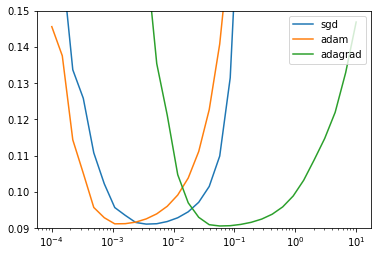

In [59]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/3 [00:00<?, ?it/s]

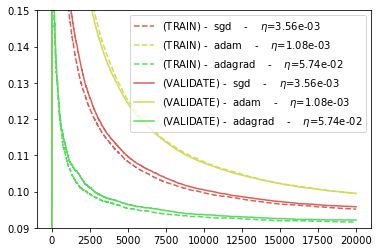

In [60]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 0.31622776601683794


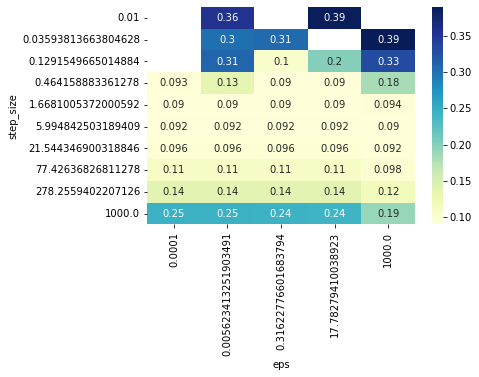

In [61]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

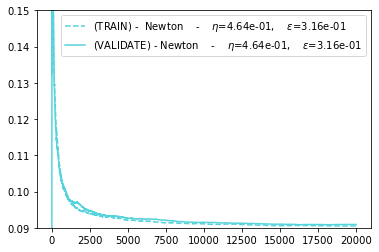

In [62]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

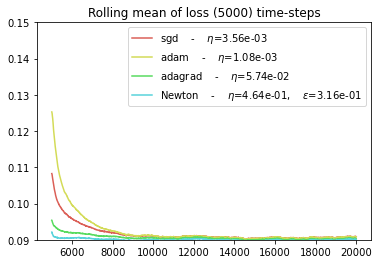

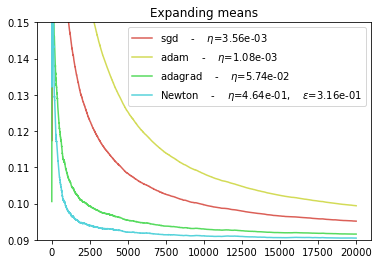

In [63]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

## Fixed setting

CPU times: user 1.82 s, sys: 20.9 ms, total: 1.84 s
Wall time: 1.83 s


<AxesSubplot:>

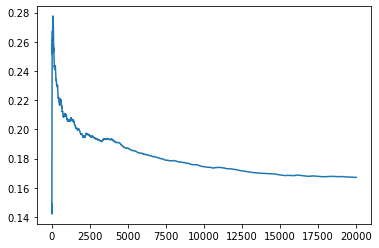

In [64]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.1, eps=0.3)), env)(eps)


eps = sample_noise(rng)
sim = unroll_transform_with_state(gym_loop_newton)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

pd.Series(-gym.reward).expanding().mean().plot()  # ylim=(MIN_ERR, MAX_ERR))

# Setting 2

let's build an environment corresponding to "setting 2" in [1]

In [65]:
from wax.modules import Counter


def build_env_setting_2():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs_1 = jnp.array([-0.4, -0.5, 0.4, 0.4, 0.1])
        ar_coefs_2 = jnp.array([0.6, -0.4, 0.4, -0.5, 0.5])
        ar_coefs = ar_coefs_1 * t / T + ar_coefs_2 * (1 - t / T)

        ma_coefs = jnp.array([0.32, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.uniform(rng, (T, 20), minval=-0.5, maxval=0.5)
    return eps


T = int(2.0e4)
MIN_ERR = 0.0833
MAX_ERR = 0.15

In [66]:
env = build_env_setting_2()

  0%|          | 0/3 [00:00<?, ?it/s]

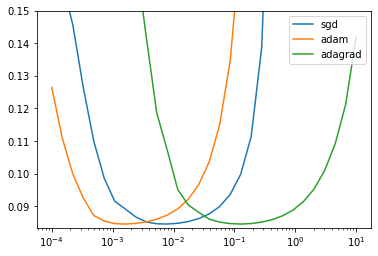

In [67]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/3 [00:00<?, ?it/s]

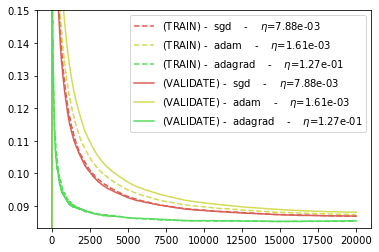

In [68]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  1.6681005372000592 17.78279410038923


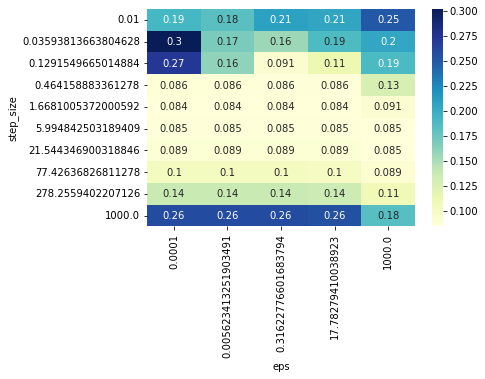

In [69]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

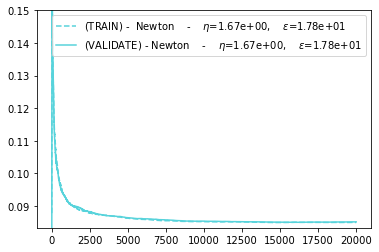

In [70]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

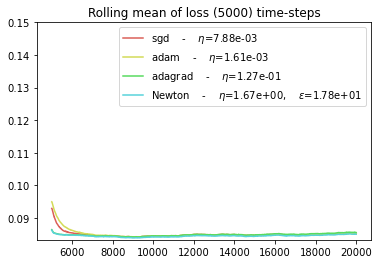

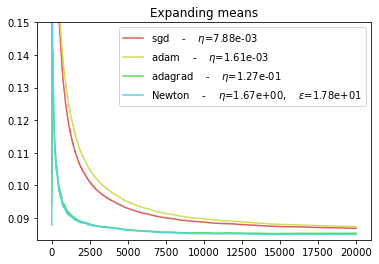

In [71]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

## Fixed setting

CPU times: user 1.93 s, sys: 21.6 ms, total: 1.95 s
Wall time: 1.95 s


<AxesSubplot:>

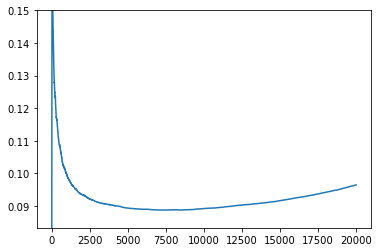

In [72]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.2, eps=0.3)), env)(eps)


eps = sample_noise(rng)
sim = unroll_transform_with_state(gym_loop_newton)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

pd.Series(-gym.reward).expanding().mean().plot(ylim=(MIN_ERR, MAX_ERR))

# Setting 3

let's build an environment corresponding to "setting 3" in [1]

In [73]:
from wax.modules import Counter


def build_env_setting_3():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs_1 = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ar_coefs_2 = jnp.array([-0.4, -0.5, 0.4, 0.4, 0.1])

        ar_coefs = jnp.where(t < T / 2, ar_coefs_1, ar_coefs_2)
        ma_coefs_1 = jnp.array([0.3, -0.2])
        ma_coefs_2 = jnp.array([-0.3, 0.2])
        ma_coefs = jnp.where(t < T / 2, ma_coefs_1, ma_coefs_2)

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.uniform(rng, (T, 20), minval=-0.5, maxval=0.5)
    return eps


T = int(2.0e4)

MIN_ERR = 0.0833
MAX_ERR = 0.15

In [74]:
env = build_env_setting_3()

  0%|          | 0/3 [00:00<?, ?it/s]

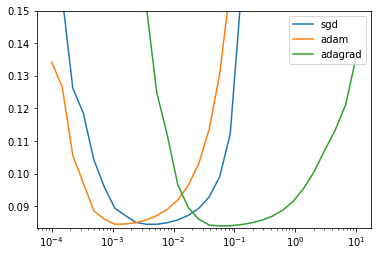

In [75]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/3 [00:00<?, ?it/s]

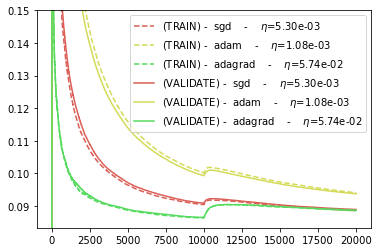

In [76]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 17.78279410038923


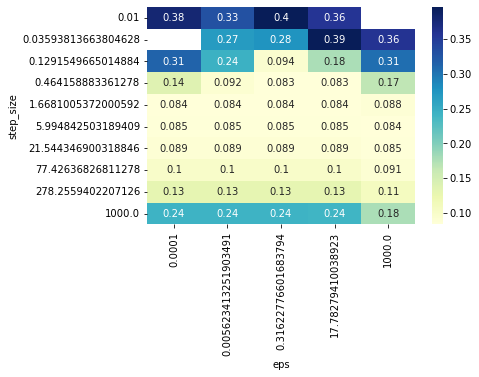

In [77]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

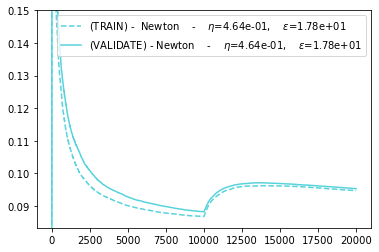

In [78]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

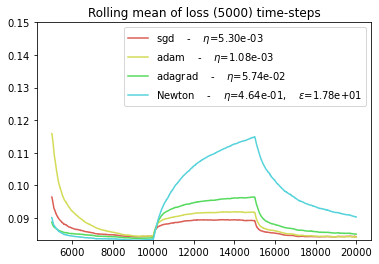

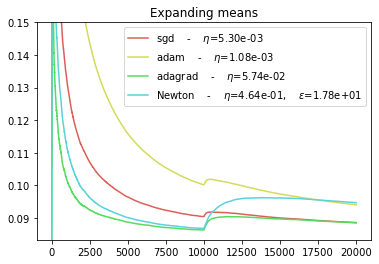

In [79]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

## Fixed setting

CPU times: user 1.98 s, sys: 23.4 ms, total: 2.01 s
Wall time: 2.01 s


<AxesSubplot:>

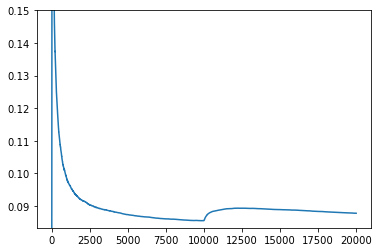

In [80]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(1.1, eps=0.3)), env)(eps)


eps = sample_noise(rng)
sim = unroll_transform_with_state(gym_loop_newton)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

pd.Series(-gym.reward).expanding().mean().plot(ylim=(MIN_ERR, MAX_ERR))

# Setting 4

let's build an environment corresponding to "setting 4" in [1]

In [81]:
from wax.modules import Counter

T = int(1.0e4)


def build_env_setting_4():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs = jnp.array([0.11, -0.5])

        ma_coefs = jnp.array([0.41, -0.39, -0.685, 0.1])

        rng = hk.next_rng_key()

        prev_eps = hk.get_state("prev_eps", (1,), init=lambda *_: jnp.zeros_like(eps))
        eps = prev_eps + eps  # jax.random.normal(rng, (1, 20))

        hk.set_state("prev_eps", eps)

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.normal(rng, (T, 20)) * 0.3
    return eps


MIN_ERR = 0.09
MAX_ERR = 0.22

In [82]:
env = build_env_setting_4()

  0%|          | 0/3 [00:00<?, ?it/s]

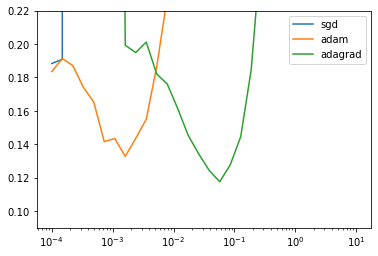

In [83]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

In [84]:
BEST_STEP_SIZE

{'sgd': 9.999999747378752e-05,
 'adam': 0.0016102619701996446,
 'adagrad': 0.05736152455210686}

  0%|          | 0/3 [00:00<?, ?it/s]

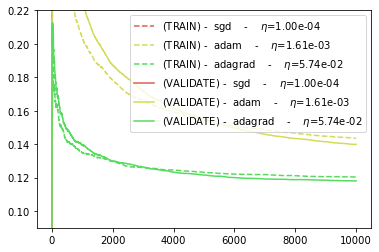

In [85]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 0.31622776601683794


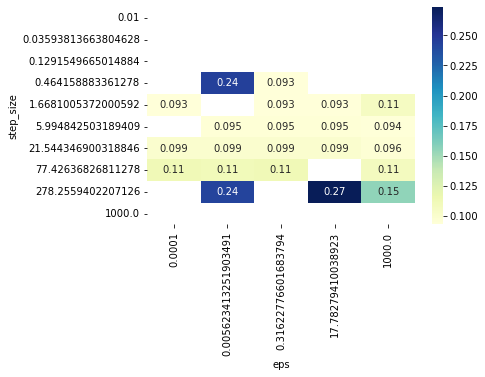

In [86]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

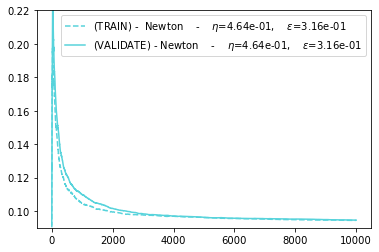

In [87]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

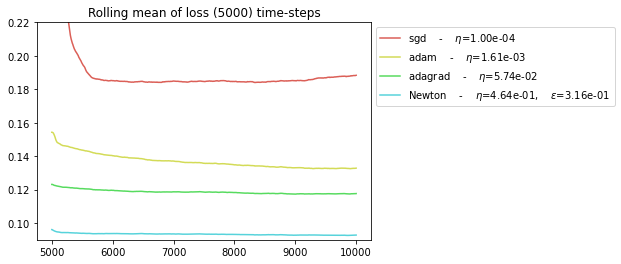

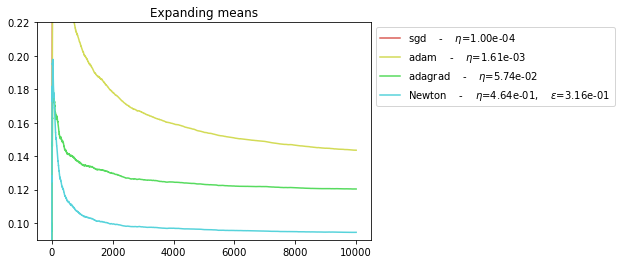

In [88]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

As noted in [1], the newton algorithm seems to be the only one to achieve an average error rate that converges to the variance of the noise (0.09).


## Fixed setting

CPU times: user 2.09 s, sys: 23.3 ms, total: 2.12 s
Wall time: 2.13 s


<AxesSubplot:>

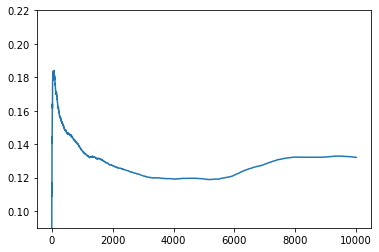

In [89]:
%%time


@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.18, eps=0.3)), env)(eps)


eps = sample_noise(rng)
sim = unroll_transform_with_state(gym_loop_newton)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

pd.Series(-gym.reward).expanding().mean().plot(ylim=(MIN_ERR, MAX_ERR))